<a href="https://colab.research.google.com/github/bartoszkozakiewicz/DeepLearning/blob/main/CityScapes_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. **DOWNLOAD AND PREPROCESS DATA**
- Data from Kaggle: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
- Data description: https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py

In [1]:
from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [2]:
from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label_lesss = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels_lesss = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label_lesss(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label_lesss(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label_lesss(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label_lesss(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label_lesss(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label_lesss(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label_lesss(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label_lesss(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label_lesss(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label_lesss(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label_lesss(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label_lesss(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label_lesss(  'wall'                 , 11 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label_lesss(  'fence'                , 11 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label_lesss(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label_lesss(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label_lesss(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label_lesss(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label_lesss(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label_lesss(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label_lesss(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label_lesss(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label_lesss(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label_lesss(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label_lesss(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label_lesss(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label_lesss(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label_lesss(  'truck'                , 26 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label_lesss(  'bus'                  , 26 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label_lesss(  'caravan'              , 26 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label_lesss(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label_lesss(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label_lesss(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label_lesss(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label_lesss(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [3]:
#car = truck = bus = caravan - 26
#builing = wall = fence
import numpy as np
id2color = { label.id : np.asarray(label.color) for label in labels }
id2colorless = { label.id : np.asarray(label.color) for label in labels_lesss }
id2colorless

{0: array([0, 0, 0]),
 1: array([0, 0, 0]),
 2: array([0, 0, 0]),
 3: array([0, 0, 0]),
 4: array([0, 0, 0]),
 5: array([111,  74,   0]),
 6: array([81,  0, 81]),
 7: array([128,  64, 128]),
 8: array([244,  35, 232]),
 9: array([250, 170, 160]),
 10: array([230, 150, 140]),
 11: array([190, 153, 153]),
 14: array([180, 165, 180]),
 15: array([150, 100, 100]),
 16: array([150, 120,  90]),
 17: array([153, 153, 153]),
 18: array([153, 153, 153]),
 19: array([250, 170,  30]),
 20: array([220, 220,   0]),
 21: array([107, 142,  35]),
 22: array([152, 251, 152]),
 23: array([ 70, 130, 180]),
 24: array([220,  20,  60]),
 25: array([255,   0,   0]),
 26: array([ 0,  0, 90]),
 30: array([  0,   0, 110]),
 31: array([  0,  80, 100]),
 32: array([  0,   0, 230]),
 33: array([119,  11,  32]),
 34: array([  0,   0, 142])}

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [5]:
#Getting access to Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##IMPORTS

In [6]:
import os
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

**TAKE FILES FROM GOOGLE DRIVE**

In [ ]:
import zipfile
#Unzip the fine annotation data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/archive.zip")
zip_ref.extractall()
zip_ref.close()

##DATA EXPLORATORY

In [ ]:
train = "/content/cityscapes_data/train"
val = "/content/cityscapes_data/val"
len(os.listdir(train)), len(os.listdir(val))

(2975, 500)

In [ ]:
for dirpath, dirnames, filenames in os.walk("/content/cityscapes_data"):
  print(f"There are {len(dirnames)} directories with {len(filenames)} images in {dirpath}")

There are 3 directories with 0 images in /content/cityscapes_data
There are 2 directories with 0 images in /content/cityscapes_data/cityscapes_data
There are 0 directories with 500 images in /content/cityscapes_data/cityscapes_data/val
There are 0 directories with 2975 images in /content/cityscapes_data/cityscapes_data/train
There are 0 directories with 500 images in /content/cityscapes_data/val
There are 0 directories with 2975 images in /content/cityscapes_data/train


(256, 512, 3)


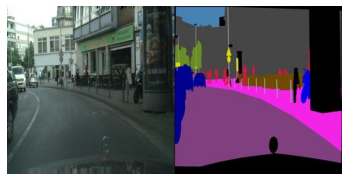

In [ ]:

random_image = random.sample(os.listdir(train),1)
img = mpimg.imread(train + "/" + random_image[0])
plt.imshow(img)
plt.axis(False)
print(img.shape)

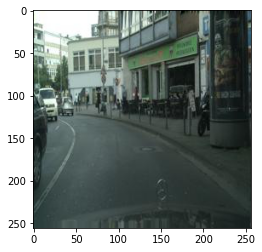

In [ ]:

plt.imshow(img[:,:256,:])

##DATA PREPROCESSING

In [ ]:
#Function to split data
def splitting_data(img_path):
  img_arr=[]
  mask_arr=[]
  for img in os.listdir(img_path):
    img_arr.append(mpimg.imread(img_path+"/"+img)[:,:256,:])
    mask_arr.append(mpimg.imread(img_path+"/"+img)[:,256:,:])
  return img_arr,mask_arr

In [ ]:
#Splitting training data
img_train,mask_train = splitting_data(train)
img_train[5].shape, mask_train[5].shape, len(img_train), len(mask_train)
del train

In [ ]:
#Splitting validation data
img_val,mask_val = splitting_data(val)
img_val[5].shape, mask_val[5].shape, len(img_val),len(mask_val)
del val

In [ ]:
#Function to visualize images
def visualize_random_img_mask(images,masks):
  for i in range(3):
    x = random.randint(0,len(images))
    plt.figure(figsize=[20,20])
    plt.subplot(2,4,i+1)
    plt.imshow(images[x])
    plt.subplot(2,4,i+2)
    plt.imshow(masks[x])
    plt.axis(False);

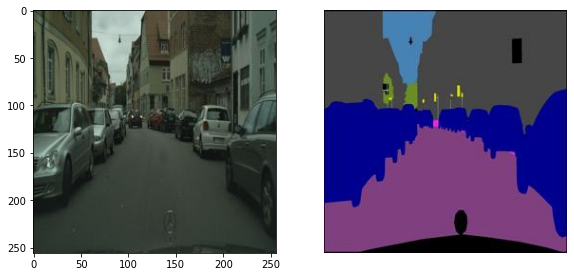

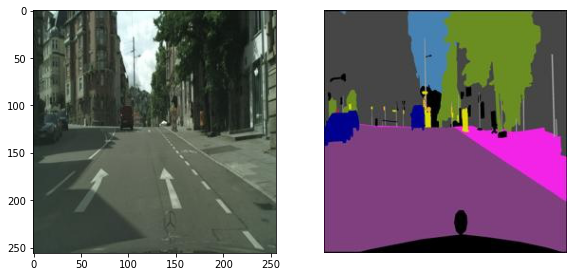

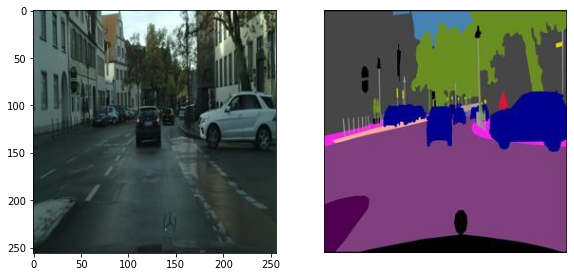

In [ ]:
#Visualize train images 
visualize_random_img_mask(img_train,mask_train)

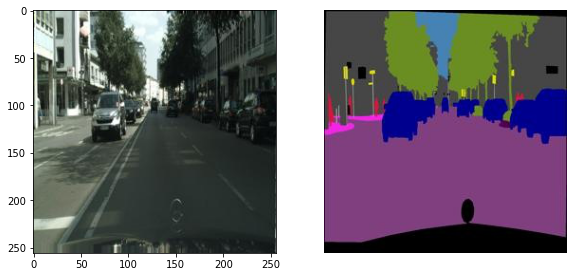

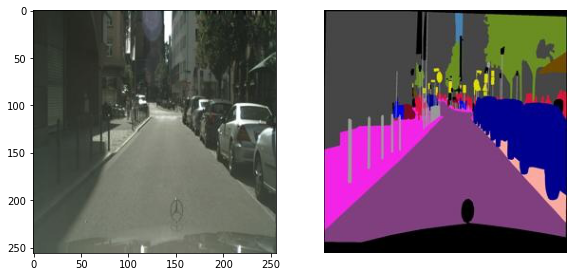

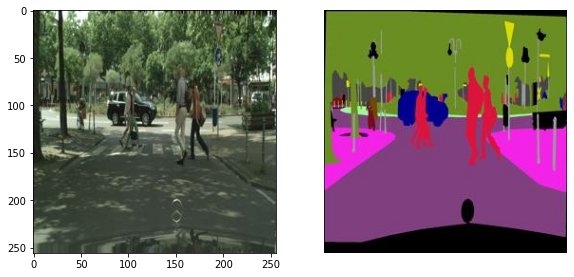

In [ ]:

#Visualize validation images
visualize_random_img_mask(img_val,mask_val)

**Encode mask - preparing for deep learning**
- Function to map colors to appropriate id

In [7]:
#Mask encoding - 35 classes
def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   
    #Pętla przechodzi zaczynając od 10000 - na pewno większych. Przypisuje pierwsze id (no i nadpisuje te dystanse/id), następnie przechodzi przez kolejne klasy i sprawdza, czy kolejny
    #dystans nie jest mniejszy niż ostatnio przypisany. Jeżeli tak - to nadpisuje nowym id, jeżeli nie to zostaje poprzednio przypisana klasa. 
    #Sprawdzenie polega na zsumowanych kwadratach różnich pod pierwiastekiem (Dystans euklidesowy)

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))#reshape for correct shape
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category) # Pixels where distance is smaller will have id exchanged

    return closest_category
#Dla zmniejszonego przypisze te same kategorie pomimo innych kolorów

**WHY LINGALG.NORM USED**

In [ ]:
catego = np.full([mask_val[0].shape[0],mask_val[0].shape[1]],None)
#for mask in mask_val:
for id, color in id2color.items():
  for row in range(mask_val[0].shape[0]):
    for col in range(mask_val[0].shape[1]):
      if np.all(mask_val[0][row][col] == color):
        catego[row][col] == id
catego
        #if id == 3 and row==2 and col==10:
         # print(mask[row][col])
#It looks like RGB colors given in github don't fit exacly to real ones..
#That's why everything is still 'None' - Thats the reason why linalg.norm is used to encode 

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

**ENCODE MASKS TO ID NUMBERS FROM COLOR**

In [ ]:
    #ENCODING TO CAUSAL - ID2COLOR
#Encoding training masks
train_mask_encoded=[]
for mask in (mask_train):
  train_mask_encoded.append(find_closest_labels_vectorized(mask, id2color))
  #Encoding validation masks
val_mask_encoded=[]
for mask in (mask_val):
  val_mask_encoded.append(find_closest_labels_vectorized(mask,id2color))


In [ ]:
#LESS
val_mask_encoded_less=[]
for mask in (mask_val):
  val_mask_encoded_less.append(find_closest_labels_vectorized(mask,id2colorless))


In [ ]:
print(f"Sample shape of train encoded mask{train_mask_encoded[0].shape} \n Length of train encoded mask: {len(train_mask_encoded)} - type {type(train_mask_encoded)}")
print(f"Sample shape of val encoded mask{val_mask_encoded[0].shape} \n Length of val encoded mask: {len(val_mask_encoded)} - type {type(val_mask_encoded[0])}")

Sample shape of train encoded mask(256, 256) 
 Length of train encoded mask: 2975 - type <class 'list'>
Sample shape of val encoded mask(256, 256) 
 Length of val encoded mask: 500 - type <class 'numpy.ndarray'>


**Visualize encoded masks to validate correctness**

In [ ]:
# To visualize, it has to be decoded to corresponding colors
def decode_and_visualize(mask_encoded,mask,image):#,mask,image
  random_ = random.randint(0,len(mask_encoded))
  decoded_mask = np.zeros([mask_encoded[random_].shape[0],mask_encoded[random_].shape[1],3])
  random_mask = mask_encoded[random_]
  for row in range(random_mask.shape[0]):
    for col in range(random_mask.shape[1]): 
        decoded_mask[row,col,:] = id2color[random_mask[row,col]]#Taking color from dictionary according to its class
        decoded_mask = decoded_mask.astype("uint8")
  print(type(decoded_mask))
  #print(decoded_mask)
  print(decoded_mask.shape, image[random_].shape,mask[random_].shape )
  #Plot
  plt.figure(figsize=[20,15])
  plt.subplot(1,3,1)
  plt.imshow(image[random_])
  plt.title("IMAGE")
  plt.axis(False);
  plt.subplot(1,3,2)
  plt.imshow(mask[random_])
  plt.title("MASK")
  plt.axis(False);
  plt.subplot(1,3,3)
  plt.imshow(decoded_mask)
  plt.title("ENCODED MASK")
  plt.axis(False);
  del decoded_mask

<class 'numpy.ndarray'>
(256, 256, 3) (256, 256, 3) (256, 256, 3)


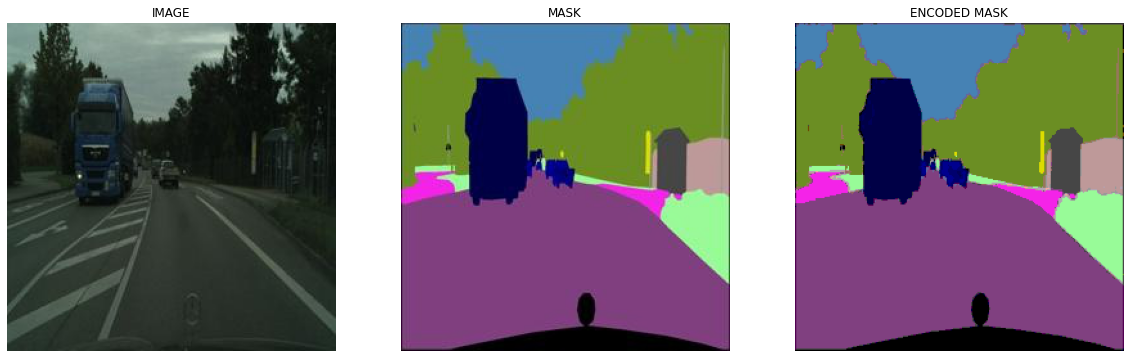

In [ ]:
#Visualize validation - encoded - masks
decode_and_visualize(val_mask_encoded,mask_val,img_val)

<class 'numpy.ndarray'>
(256, 256, 3) (256, 256, 3) (256, 256, 3)


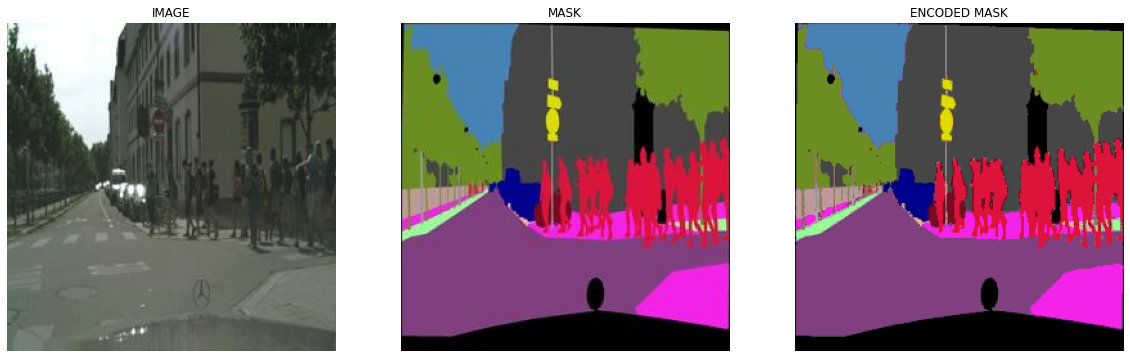

In [ ]:
#Visualize training - encoded - masks
decode_and_visualize(train_mask_encoded,mask_train,img_train)

** Preprocess **(img_train ,train_mask_encoded)** and **(img_val,val_mask_encoded)** to appropriate format for faster training**

**Prepare images**
- Preprocess function
- Prefetch Tensors

In [8]:
def preprocess_img(image):
  #img = tf.image.resize(img, [img_size,img_size])
  img = tf.cast(image,tf.float32)
  img = img/255.0
  return img

#x= preprocessing.Rescaling(1/255.)(X) or in augmentation layer  - To normalize ?

In [ ]:
img_train_ds = tf.data.Dataset.from_tensor_slices(img_train).map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=10).prefetch(tf.data.AUTOTUNE)
img_val_ds = tf.data.Dataset.from_tensor_slices(img_val).map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=10).prefetch(tf.data.AUTOTUNE)
img_train_ds,img_val_ds

(<PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>,
 <PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

In [ ]:
#Batches size
len(img_val_ds), len(img_train_ds)

(50, 298)

**TRAIN MASKS**

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

#num_t,height_t,width_t = np.array(train_mask_encoded).shape

  #Encoding - with Label encoder (to be from 0-28)
#train_mask_encoded_reshape = np.array(train_mask_encoded).reshape(-1,1)
#del train_mask_encoded
#train_mask_encoded_le = label_encoder.fit_transform(train_mask_encoded_reshape)
#del train_mask_encoded_reshape

######## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  #Create weights for unbalanced classes
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                    #             classes=np.unique(train_mask_encoded_le),
                                   #              y=train_mask_encoded_le)
#dict_weights = {i:val for i,val in enumerate(class_weights)}
######## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  #Prepare for right shape and type for training/val
train_mask_encoded = np.asarray(train_mask_encoded).astype('float32')
#train_mask_encoded_le = train_mask_encoded.reshape(num_t,height_t,width_t)
train_mask_encoded_le_input = np.expand_dims(train_mask_encoded, axis=3)
#del train_mask_encoded_le

  #Making prefetch Dataset - for faster training
mask_train_ds = tf.data.Dataset.from_tensor_slices(train_mask_encoded_le_input).batch(batch_size=10).prefetch(tf.data.AUTOTUNE)

  #Take classes from label encoder - maybe will be usefull later
#classes = label_encoder.classes_

  #Converting to categorical - one-hot-encoding
#mask_train_ds = to_categorical(train_mask_encoded_le_input,num_classes=len(classes))
#del train_mask_encoded_le_input

**VALIDATION MASKS**

In [ ]:
#num_m,height_m,width_m = np.array(val_mask_encoded).shape

  #Encoding - with Label encoder (to be from 0-28)
#val_mask_encoded_reshape = np.array(val_mask_encoded).reshape(-1,1)
#del val_mask_encoded
#val_mask_encoded_le = label_encoder.transform(val_mask_encoded_reshape)
#del val_mask_encoded_reshape

  #Prepare for right shape and type for training/val
val_mask_encoded = np.asarray(val_mask_encoded).astype('float32')
#val_mask_encoded_le = val_mask_encoded.reshape(num_m,height_m,width_m)
val_mask_encoded_le_input = np.expand_dims(val_mask_encoded, axis=3)
#del val_mask_encoded_le

  #Making prefetch Dataset - for faster training
mask_val_ds = tf.data.Dataset.from_tensor_slices(val_mask_encoded_le_input).batch(batch_size=10).prefetch(tf.data.AUTOTUNE)

  #Converting to categorical - one-hot-encoding
#mask_val_ds = to_categorical(val_mask_encoded_le_input,num_classes=len(classes))
#del val_mask_encoded_le_input

In [ ]:
#Final Data for training and validation
train_ds =  tf.data.Dataset.zip((img_train_ds,mask_train_ds))
del img_train_ds, mask_train_ds
val_ds = tf.data.Dataset.zip((img_val_ds,mask_val_ds))
del img_val_ds, mask_val_ds
val_ds,train_ds

(<ZipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <ZipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>)

##MIXED PRECISION 
- For faster training

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Concatenate, BatchNormalization,Input,Dropout,Conv2DTranspose, PReLU, Add,ReLU, Softmax
import tensorflow as tf
import torch
#import tensorflow_addons as tfa

In [ ]:

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")#Global data policy to mixed precision - mixing float16 and float32 if possible
mixed_precision.global_policy()

<Policy "mixed_float16">

##2. **BUILING UNET MODEL**

In [ ]:
def unet_model(IMG_WIDTH=256, IMG_HEIGHT=256, N_CLASSES=35, IMG_CHANNELS = 3):

#Encoding Part (Contracting Path) - 3x3Conv - Unpadded + ReLU - CO Z DROPOUTEM ? 
# 1.Czy robić z dropoutem
# 2.Czy robić padding=valid i cropować / Czy dać padding=same
  input = Input(shape=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),name="Input_Layer")
  e1 = Conv2D(filters=64,kernel_size=3,padding="same",activation="relu",kernel_initializer = 'he_normal')(input)
  e1 = Dropout(0.15)(e1)
  e1 = Conv2D(filters=64,kernel_size=3,padding="same",activation="relu",kernel_initializer = 'he_normal')(e1)
  m1 = MaxPool2D(pool_size=2,strides=2)(e1)

  e2 = Conv2D(128,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(m1)
  e2 = Dropout(0.15)(e2)
  e2 = Conv2D(128,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(e2)
  m2 = MaxPool2D(2,2)(e2)

  e3 = Conv2D(256,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(m2)
  e3 = Dropout(0.15)(e3)
  e3 = Conv2D(256,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(e3)
  m3 = MaxPool2D(2,2)(e3)  

  e4 = Conv2D(512,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(m3)
  e4 = Dropout(0.15)(e4)
  e4 = Conv2D(512,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(e4)
  m4 = MaxPool2D(2,2)(e4)  

  e5 = Conv2D(1024,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(m4)
  e5 = Dropout(0.15)(e5)
  e5 = Conv2D(1024,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(e5)  

#Decoding Part (Expansive Path)  
  d1 = Conv2DTranspose(filters=512,kernel_size=2,strides=(2,2),padding="same")(e5) #To double h,w there is kernel and stride = 2 needed
  d1 = Concatenate()([d1,e4]) # Cropping - tf.image.resize_images() to get same height/width
  d1 = Conv2D(512,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d1)
  #d1 = Dropout(0.1)(d1)
  d1 = Conv2D(512,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d1)

  d2 = Conv2DTranspose(filters=256,kernel_size=2,strides=(2,2),padding="same")(d1) #To double h,w there is kernel and stride = 2 needed
  d2 = Concatenate()([d2,e3])
  d2 = Conv2D(256,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d2)
  #d2 = Dropout(0.1)(d2)
  d2 = Conv2D(256,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d2)

  d3 = Conv2DTranspose(filters=128,kernel_size=2,strides=(2,2),padding="same")(d2) #To double h,w there is kernel and stride = 2 needed
  d3 = Concatenate()([d3,e2])
  d3 = Conv2D(128,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d3)
  #d3 = Dropout(0.1)(d3)
  d3 = Conv2D(128,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d3)

  d4 = Conv2DTranspose(filters=64,kernel_size=2,strides=(2,2),padding="same")(d3) #To double h,w there is kernel and stride = 2 needed
  d4 = Concatenate()([d4,e1])
  d4 = Conv2D(64,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d4)
  #d4 = Dropout(0.1)(d4)
  d4 = Conv2D(64,3,padding="same",activation="relu",kernel_initializer = 'he_normal')(d4) 

  output = Conv2D(filters=N_CLASSES,kernel_size=1,dtype=tf.float32)(d4)
  model = tf.keras.Model(inputs=input,outputs=output)

#Compile model
  model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# tfa.losses.SigmoidFocalCrossEntropy()- categorical, thus one-hot
                optimizer="adam",
                metrics=["accuracy"])#tf.keras.metrics.MeanIoU(num_classes=N_CLASSES,name="iou")
  return model


##TRAIN U-NET MODEL

In [ ]:
unet_model_d15= unet_model()
unet_model_d15.summary() #poprzednie

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['Input_Layer[0][0]']            
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
 #Visualize U-net architecture
 from keras.utils import plot_model
 plot_model(unet_model, show_shapes=True)

In [ ]:
#Create callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/Colab Notebooks/Unet_checkpointd2",
                                                      save_best_only=True,
                                                      verbose=1,
                                                      monitor="val_accuracy",#val_iou
                                                      mode="max")#...

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",#...
                                                  patience=10)   
     
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",  
                                                 factor=0.5, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)                                             

In [ ]:
#Fitting 
unet_history_d15 = unet_model_d15.fit(train_ds,
                              epochs=60,
                              steps_per_epoch = len(train_ds),
                              validation_data = val_ds,
                              validation_steps=int(0.2*len(val_ds)),
                              #class_weight = dict_weights,
                              callbacks=[model_checkpoint,early_stopping,reduce_lr])#early_stopping

Epoch 1/60
  2/298 [..............................] - ETA: 447:47:53 - loss: 3.3867 - accuracy: 0.0156

**Rodzaje konfiguracji**
- Unet_checkpoint_dropout_CE_long - model, który ma dropout na encoderze tylko, między Conv2D - dropout =  0.1
- Unet_checkpoint_no_drop  - model, który nie ma dropoutu - na 50 epoch
- Unet_checkpoint_all_drop - model, który ma dropout w encoderze i dekoderze, dropout=0.1

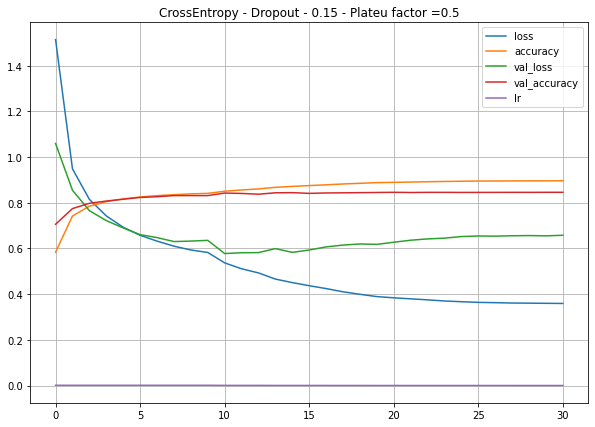

In [ ]:
import pandas as pd
pd.DataFrame(unet_history_d15.history).plot(figsize=(10,7))
plt.grid(True)
plt.title("CrossEntropy - Dropout - 0.15 - Plateu factor =0.5");

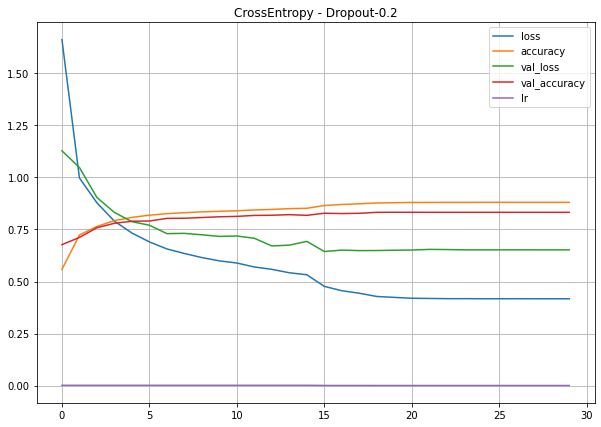

In [ ]:
import pandas as pd
pd.DataFrame(unet_history_d2.history).plot(figsize=(10,7))
plt.grid(True)
plt.title("CrossEntropy - Dropout-0.2");

In [ ]:
#Evaluation of model which have dropout on Encoder only
unet_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/Unet_checkpoint2_0022.ckpt") # 29
val_loss_drop, val_accuracy_drop = unet_model.evaluate(val_ds)

50/50 [==============================] - 3s 63ms/step - loss: 0.6852 - accuracy: 0.8304


In [ ]:
unet_model_d2_loaded = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Unet_checkpointd2')
val_loss_d2, val_accuracy_d2 = unet_model_d2_loaded.evaluate(val_ds)
#Zmniejszyc na nastepnym traniengu factor w Plateu

50/50 [==============================] - 4s 63ms/step - loss: 0.6108 - accuracy: 0.8422


In [ ]:
unet_model_d15_loaded = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/Unet_checkpointd2')
val_loss_d15, val_accuracy_d15 = unet_model_d15_loaded.evaluate(val_ds)

50/50 [==============================] - 3s 60ms/step - loss: 0.6613 - accuracy: 0.8403


In [ ]:
unet_model_d15_loaded.save("UNETD15P5")

In [ ]:
#SAVE MODEL 
#unet_model_d2_loaded.save("UNETD2P2.h5")
load_mod = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/UNET_D0.2_Plateu0.2')
load_mod.evaluate(val_ds)

50/50 [==============================] - 3s 59ms/step - loss: 0.6108 - accuracy: 0.8422


[0.6108389496803284, 0.8422232866287231]

In [7]:
load_mod15 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/UNETD15P5.h5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


##VISUALIZE RESULTS GIVEN FROM UNET MODEL




In [ ]:
#Mapowanie w przypadku Label Encodera + OneHot (Za dużo pamięci zajmuje)
#mapowanie_spowrotem = {i:val for i,val in enumerate(classes)}
#mapowanie_spowrotem

In [ ]:
def visualize_random_prediction(image,mask,model):
  #Make prediction
  import random 
  random_ = random.randint(0,len(image))
  prep_img = np.asarray(preprocess_img(image[random_]))
  prediction =model.predict(prep_img.reshape([1]+[256,256]+[3,]))
  #Prepare for plot - reshape -> to (256,256), where pixels are classes from id2color
  prediction = np.squeeze(np.argmax(prediction,axis=-1))


  #for row in range(prediction.shape[0]):
  #  for col in range(prediction.shape[1]):
  #    prediction[row][col] = mapowanie_spowrotem[prediction[row][col]]

  #map from id2color classes to RGB
  decoded_mask = np.zeros([image[random_].shape[0],image[random_].shape[1],3])
  for row in range(prediction.shape[0]):
    for col in range(prediction.shape[1]):
      decoded_mask[row,col,:] = id2color[prediction[row,col]]
      decoded_mask = decoded_mask.astype("uint8")

  #Custom decoded mask
  linalg_dec = np.zeros([image[random_].shape[0],image[random_].shape[1],3])
  encoded = find_closest_labels_vectorized(mask[random_], id2color)
  for row in range(encoded.shape[0]):
    for col in range(encoded.shape[1]):
      linalg_dec[row,col,:] = id2color[encoded[row,col]]
      linalg_dec = linalg_dec.astype("uint8")

  #Plot
  plt.figure(figsize=[20,15])
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(image[random_].reshape([1]+[256,256]+[3,])))
  plt.title("IMAGE")
  plt.subplot(1,3,2)
  plt.imshow(linalg_dec)
  plt.title("ENCODED MASK")
  plt.subplot(1,3,3)
  plt.imshow(decoded_mask)
  plt.title("PREDICTED MASK")
  plt.axis(False);

In [ ]:
visualize_random_prediction()

1/1 [==============================] - 0s 335ms/step
(array([ 0,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 26, 27, 28,
       29, 30]), array([ 3655,   177, 17609,  9252, 22694,   273,    87,     4,     2,
           4,     6,  7201,    71,  1863,  2316,   113,     4,    14,
         191]))
(array([ 0,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 26, 27, 28,
       29, 30]), array([ 3655,   177, 17609,  9252, 22694,   273,    87,     4,     2,
           4,     6,  7201,    71,  1863,  2316,   113,     4,    14,
         191]))


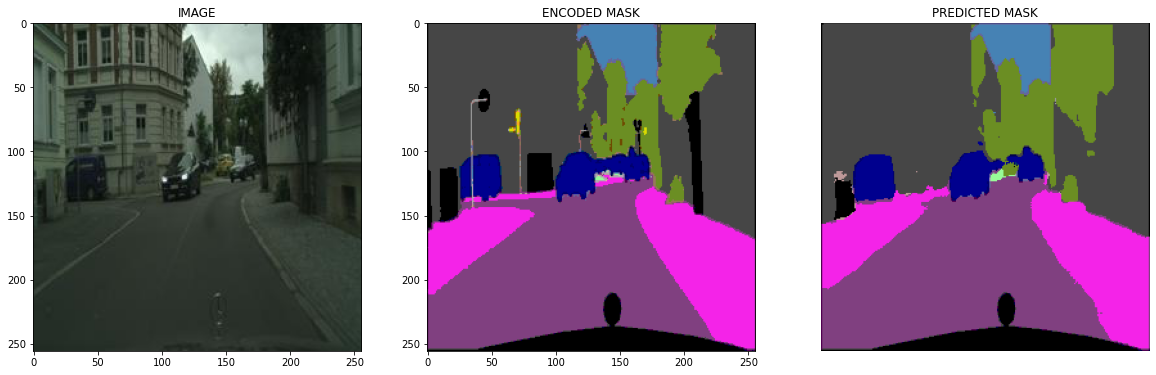

In [ ]:
#Visualized model drop-0.1 without Plateu
visualize_random_prediction(img_val,img_val)

1/1 [==============================] - 0s 26ms/step


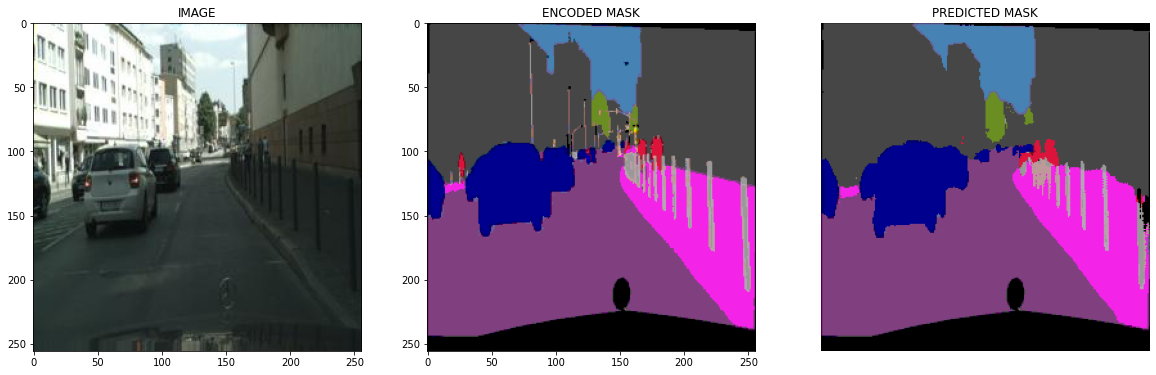

In [ ]:
#Visualize predictions from model - unet_model_d2_loaded - drop=0.2 / Plateu = 0.2
visualize_random_prediction(img_val,mask_val,unet_model_d2_loaded)

##CAPTURE VIDEO - FUNCTION

In [9]:
import cv2
def get_frames(video):
  frames = []
  # Open the video file
  video_capture = cv2.VideoCapture(video)
  # Check if the video file was opened successfully
  if not video_capture.isOpened():
      print('Error opening video file')
      exit()

  # Initialize frame counter
  frame_count = 0
  # Loop through the video frames
  while True:
      # Read the next frame from the video
      success, frame = video_capture.read()
      # Check if the frame was read successfully
      if not success:
          break
      frame_count+=1
      filename = f'frame_{frame_count}.jpg'
      cv2.imwrite(filename, frame)    
      frames.append(filename)
    
  return frames


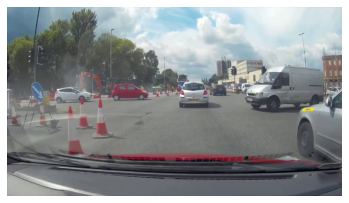

In [10]:
frames = get_frames('f1.mp4')
import matplotlib.pyplot as plt
p = plt.imread(frames[10])
plt.imshow(p)
plt.axis(False);

##FRAMES PREDICTIONS - FUNCTION

In [11]:
import tensorflow as tf
def eval_video(frames,model):
  images=[]
  decoded_frames=[]
  #Make predicted images (each frame from video)
  for img in frames:
    frame = mpimg.imread(img)
    frame = tf.image.resize(frame,[256,256])
    images.append(frame)
  eval_frames = tf.data.Dataset.from_tensor_slices(images)
  eval_frames = eval_frames.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=10).prefetch(tf.data.AUTOTUNE)
  pred_frames = model.predict(eval_frames)
  decoded_mask = np.zeros([pred_frames[0].shape[0],pred_frames[0].shape[1],3])
  for pred in pred_frames:
    pred = np.squeeze(np.argmax(pred,axis=-1))
    for row in range(pred.shape[0]):
        for col in range(pred.shape[1]):
            decoded_mask[row,col,:] = id2color[pred[row,col]]
            decoded_mask = decoded_mask.astype("uint8")
    decoded_frames.append(decoded_mask)  
  return decoded_frames

In [ ]:
pred_images = eval_video(frames,load_mod15)

 9/13 [===================>..........] - ETA: 9:45 

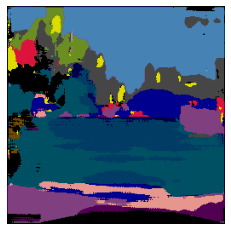

In [36]:
plt.imshow(pred_images[100])
plt.axis(False);

##CONVERT TO VIDEO - FUNCTION

In [ ]:
def vid_conv(images,vid_name):
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  fps=30

  vid = cv2.VideoWriter(vid_name,fourcc,fps,(256,256))
  for frame in images:
    vid.write(frame)
  cv2.destroyAllWindows()
  video.release()

In [ ]:
vid_conv(pred_images,"seg.mp4")

#BUILDING SEGNET MODEL

**Encoder**

In [ ]:
import numpy as np
class encoder:
  def __init__(self,img_size):
    self.img_size = img_size
    self.id = []
  def input(self):
    input = Input(shape=(self.img_size,self.img_size,3))
    return input
  def enc_block2(self,filters,go):
    x = Conv2D(filters=filters,kernel_size=3,strides=1,padding='same')(go)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,kernel_size=3,strides=1,padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    #print(type(torch.from_numpy(x)))
    #x, idx = torch.nn.functional.max_pool2d(torch.from_numpy(np(x)), kernel_size=2, stride=2, return_indices=True)  #Tutaj indices powinny być zbierane w MaxPool encodera ogolnie
    #self.id.append(idx)
    return x

  def enc_block3(self,filters,gor):
    x = Conv2D(filters=filters,kernel_size=3,strides=1,padding='same')(gor)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,kernel_size=3,strides=1,padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,kernel_size=3,strides=1,padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x,idx = torch.nn.MaxPool2d(stride=(2,2),kernel_size=2,return_indices=True,)(x)
    self.id.append(idx)
    return xgg
  def model(self,inputs,outputs):
    y = tf.keras.Model(inputs=inputs, outputs=outputs)
    return y

#Build encoder
enc = encoder(256)
input = enc.input()
encoder = enc.enc_block2(64,input)
encoder = enc.enc_block2(128,encoder)
encoder = enc.enc_block3(256,encoder)
encoder = enc.enc_block3(512,encoder)
encoder = enc.enc_block3(512,encoder)
encoder = enc.enc_block3(512,encoder)
model = enc.model(input, encoder)

In [ ]:
tes = torch.tensor([[[[ 1.,  2.,  3.,  4.],
                            [ 5.,  6.,  7.,  8.],
                            [ 9., 10., 11., 12.],
                            [13., 14., 15., 16.]]]])
tes_ten = tf.constant([[[[ 1.,  2.,  3.,  4.],
                            [ 5.,  6.,  7.,  8.],
                            [ 9., 10., 11., 12.],
                            [13., 14., 15., 16.]]]])
pool = torch.nn.MaxPool2d(2, stride=2, return_indices=True,padding=1)
tor, i = pool(tes)
test23 = MaxPool2D(padding='valid',strides=(2,2))(tf.reshape(tes_ten,(1,4,4,1)))
tes, tor,i,test23


**Decoder**

In [ ]:
class decoder:
  def __init__(self,n_class):
    self.n_class = n_class
  def output(self,x):
    x = Softmax()(x)
    return x
  def dec_block2(self,filters,x,is_out):
    #Upsampling - to do 
    x = Conv2D(filters=filters, kernel_size=3,strides=1,padding="same")(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    if is_out:
      x = Conv2D(filters=self.n_class, kernel_size=3,strides=1,padding="same")(x) # Last one with n classes
    else:
      x = Conv2D(filters=filters, kernel_size=3,strides=1,padding="same")(x) 
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)     
    return x
  def dec_block3(self,filters,x):
    #Upsampling - to do
    x = Conv2D(filters=filters, kernel_size=3,strides=1,padding="same")(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters, kernel_size=3,strides=1,padding="same")(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters, kernel_size=3,strides=1,padding="same")(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

#Build decoder
dec = decoder(35) # 35 classes
decoder = dec.dec_block2(512,encoder,False)
decoder = dec.dec_block3(,decoder)#fill
decoder = dec.dec_block3(,decoder)#fill
decoder = dec.dec_block2(,decoder)#fill
output = dec.output(decoder)

**Test**

In [ ]:
import numpy as np
testowo = tf.constant([[[[1.,2.,3.,4.],
              [5.,6.,7.,8.],
              [10.,11.,12.,13.],
              [14.,15.,16.,17.]]]])
t = MaxPool2D(strides=(2,2),pool_size=(2,2))(testowo)
print(np.asarray(t))

[]


In [ ]:
import torch
from torch import nn
input = torch.tensor([[[[ 1.,  2.,  3.,  4.],
                            [ 5.,  6.,  7.,  8.],
                            [ 9., 10., 11., 12.],
                            [13., 14., 15., 16.]]]])
pool = nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2,return_indices=True)
output, indices = pool(input)
output, indices = unpool(input)
output, indices 


##3. **BUILDING ENET MODEL**

In [ ]:
def enet_model(IMG_WIDTH=256, IMG_HEIGHT=256, N_CLASSES=29, IMG_CHANNELS = 3):
#Initial layer
  input = Input(shape=(IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),name="Input_Layer")
  init = Conv2D(filers=13,kernel_size=3,strides=2)(input)
  initp = MaxPool2D(2,2)(input) #strides = 2 To not overlap
  init = Concatenate()([init,initp])
#bottleneck1.0 - Downsampling
  b1m = MaxPool2D(2,2,padding="same")(init) #...?

  b1 = Conv2D(filters=, 2,2,padding="same")(init) # 1x1 - As 2,2,(same ?) - because downsampling
  b1 = PReLU()(b1) # Make alpha param trainable for all PReLU in the future
  b1 = BatchNormalization()(b1)

  b1 = Conv2D(filters=,3)(b1)
  b1 = PReLU()(b1)
  b1 = BatchNormalization()(b1)

  b1 = Conv2D(filters=,1)(b1)
  b1 = Dropout(0.01)(b1)
  b1 = Add()([b1m,b1])

    #Normal - 4xbottleneck_1
  for i in range(4):
    b1 = Conv2D(filters=,1)(b1)
    b1 = PReLU()(b1)
    b1 = BatchNormalization()(b1)

    b1 = Conv2D(filters=,3)(b1)  
    b1 = PReLU()(b1)
    b1 = BatchNormalization()(b1)

    b1 = Conv2D(filters=,1)(b1)
    b1 =Dropout(0.01)(b1)
#bottleneck2.0

#TRAIN ENET MODEL

In [ ]:
import tensorflow as tf
from tf.keras.applications.vgg16 import vgg16
vgg = VGG16(weights='imagenet')
vgg.summary()

#Check

In [ ]:
np.full([mask_train[1].shape[0], mask_train[1].shape[1]], 10000).shape

In [ ]:
mask_train[0]

In [ ]:
id2color.items()

In [ ]:
blabla=[]
for id, color in id2color.items():
  blabla.append(color.reshape([1,1,-1]))
blabla[9]

In [ ]:
cos[0]

In [ ]:
(mask_train[0]-blabla[9])

In [ ]:
np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0])

In [ ]:
 closest_distance = np.full([mask_train[1].shape[0], mask_train[1].shape[1]], 10000)
 closest_distance > np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0])

In [ ]:
np.where( closest_distance > np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0]), np.sqrt(np.linalg.norm(mask_train[0]-blabla[9], axis=-1)[0]), closest_distance)
